# <center>Time Series Analysis on Pune precipitation data from 1965 to 2002.</center>

## <center>Algorithm: LSTM(Long Short Term Memory) </center>

### Import libraries

In [712]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import itertools
import warnings
warnings.filterwarnings('ignore')

### Filename

In [713]:
filename = 'pune_1965_to_2002.csv'

### Data
- Downloaded from http://www.indiawaterportal.org/met_data/
- State: Maharashtra
- District: PUNE
- Data type: Precipitation
- Data Range: Monthly mean precipitation for all the years from 1972 to 2002

### Transpose data for easy visualiztion

In [714]:
rainfall_data_matrix = pd.read_csv(filename, delimiter='\t')
rainfall_data_matrix.set_index('Year', inplace=True)
rainfall_data_matrix = rainfall_data_matrix.transpose()
rainfall_data_matrix

Year,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,...,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002
Jan,0.029,0.905,0.248,0.318,0.248,0.070,0.000,0.000,0.000,0.000,...,0.000,0.879,0.695,0.016,1.284,0.008,0.000,0.000,0.147,0.231
Feb,0.069,0.000,3.390,3.035,2.524,0.000,0.000,0.029,2.969,0.000,...,0.078,0.325,0.000,2.779,0.000,2.671,1.431,0.170,0.000,0.911
Mar,0.000,0.000,1.320,1.704,0.334,0.001,0.000,0.000,0.234,6.427,...,1.211,2.415,1.770,0.087,0.747,0.073,0.000,0.000,2.178,0.388
Apr,21.667,2.981,13.482,23.307,4.569,16.218,0.812,5.982,3.925,16.864,...,2.062,16.823,25.949,6.318,23.912,0.377,0.642,1.193,1.528,53.266
May,17.859,63.008,11.116,7.441,6.213,68.036,57.691,19.101,14.978,51.209,...,3.248,33.378,23.964,5.134,4.664,15.717,35.828,26.237,7.860,18.430
Jun,102.111,94.088,251.314,179.872,393.682,300.546,297.187,132.413,304.484,148.697,...,234.068,749.030,163.515,453.607,673.831,238.609,415.471,371.328,247.982,509.145
Jul,606.071,481.942,780.006,379.354,678.354,330.502,122.195,338.484,696.024,405.359,...,450.088,707.986,501.461,558.586,422.913,590.663,277.137,265.417,279.547,84.936
Aug,402.521,59.386,181.069,171.979,397.335,283.476,372.693,68.741,256.932,319.651,...,150.278,230.898,114.206,212.489,541.579,362.357,98.616,220.814,189.404,257.205
Sep,69.511,150.624,183.757,219.884,205.413,158.640,286.056,120.415,183.206,288.533,...,101.928,115.509,288.262,203.642,60.477,243.444,225.962,147.196,158.025,78.269
Oct,5.249,1.308,50.404,73.997,24.014,115.758,39.424,1.078,101.805,188.876,...,225.904,116.348,84.359,176.471,31.050,96.324,180.300,38.246,135.518,21.486


### Genearete dates from 1965-01(January 1965) to 2002-12(December 2002)

In [715]:
dates = pd.date_range(start='1965-01', freq='MS', periods=len(rainfall_data_matrix.columns)*12)
dates

DatetimeIndex(['1965-01-01', '1965-02-01', '1965-03-01', '1965-04-01',
               '1965-05-01', '1965-06-01', '1965-07-01', '1965-08-01',
               '1965-09-01', '1965-10-01',
               ...
               '2002-03-01', '2002-04-01', '2002-05-01', '2002-06-01',
               '2002-07-01', '2002-08-01', '2002-09-01', '2002-10-01',
               '2002-11-01', '2002-12-01'],
              dtype='datetime64[ns]', length=456, freq='MS')

### Visualize the whole data

Text(0.5,1,'Month vs Precipitation across all years')

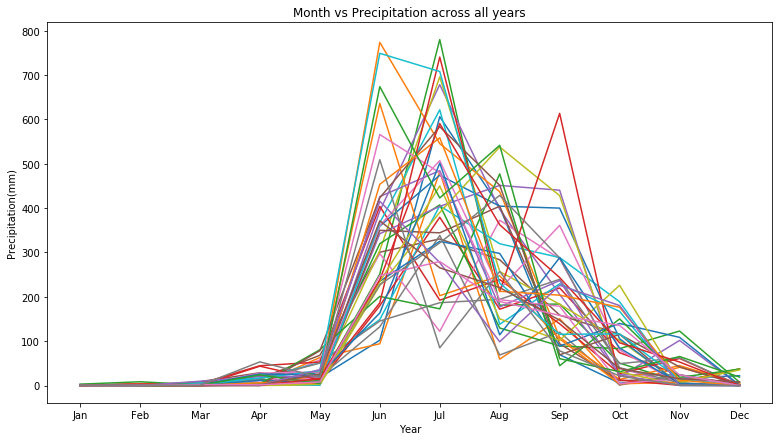

In [716]:
plt.figure(figsize=(13,7))
plt.plot(rainfall_data_matrix)
plt.xlabel('Year')
plt.ylabel('Precipitation(mm)')
plt.title('Month vs Precipitation across all years')

### Box plot

Text(0.5,1,'Month vs Precipitation across all years')

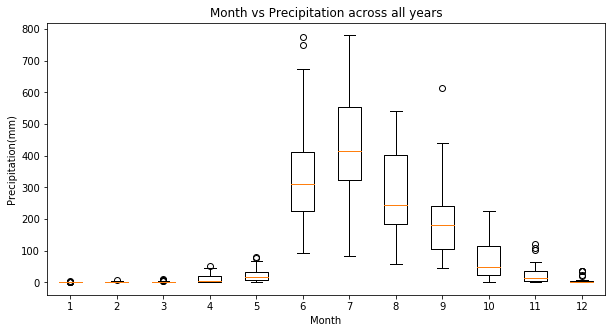

In [717]:
plt.figure(figsize=(10,5))
plt.boxplot(rainfall_data_matrix)
plt.xlabel('Month')
plt.ylabel('Precipitation(mm)')
plt.title('Month vs Precipitation across all years')

### Insights from the plot
- The rainfall in the months November, December, January, February, March and April is very less.
- The rainfall in the months June, July and August are high compared to rainfall in other months of the year. 
- We can observe the seasonality effect.

In [718]:
rainfall_data_matrix_np = rainfall_data_matrix.transpose().as_matrix()

shape = rainfall_data_matrix_np.shape
rainfall_data_matrix_np = rainfall_data_matrix_np.reshape((shape[0] * shape[1], 1))

### Split the whole data into train(1965 - 1995) and test data(1995 - 2002)

In [719]:
rainfall_data = pd.DataFrame({'Precipitation': rainfall_data_matrix_np[:,0]})
rainfall_data.set_index(dates, inplace=True)

test_rainfall_data = rainfall_data.ix['1995': '2002']
rainfall_data = rainfall_data.ix[: '1994']
rainfall_data.head()

,Precipitation
1965-01-01,0.029
1965-02-01,0.069
1965-03-01,0.000
1965-04-01,21.667
1965-05-01,17.859


### Visualize data

Text(0.5,1,'Precipitation in mm')

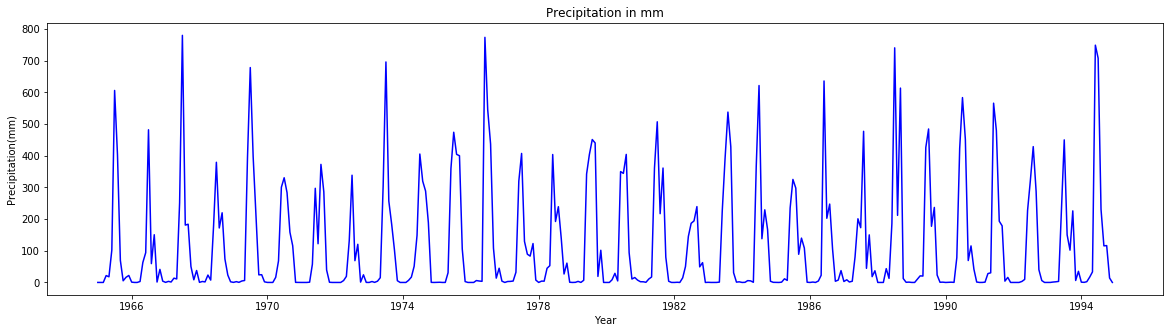

In [720]:
plt.figure(figsize=(20,5))
plt.plot(rainfall_data, color='blue')
plt.xlabel('Year')
plt.ylabel('Precipitation(mm)')
plt.title('Precipitation in mm')

### Visualize data(zoomed version) - 5 years(1972 - 1977)

Text(0.5,1,'Precipitation in mm')

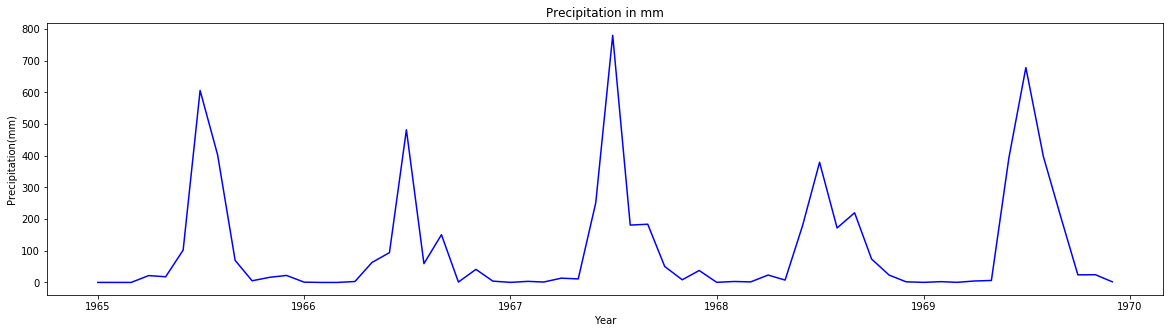

In [721]:
plt.figure(figsize=(20,5))
plt.plot(rainfall_data.ix[:60], color='blue')
plt.xlabel('Year')
plt.ylabel('Precipitation(mm)')
plt.title('Precipitation in mm')

### LSTM

### Scale the data - (0 to 1)

In [722]:
scaler = MinMaxScaler(feature_range=(0, 1))

train_data = scaler.fit_transform(rainfall_data)
test_data = scaler.fit_transform(test_rainfall_data)

In [723]:
rainfall_data.head()

,Precipitation
1965-01-01,0.029
1965-02-01,0.069
1965-03-01,0.000
1965-04-01,21.667
1965-05-01,17.859


In [724]:
train_data[:5]

array([[3.71792012e-05],
       [8.84608580e-05],
       [0.00000000e+00],
       [2.77779915e-02],
       [2.28959777e-02]])

In [725]:
scaler.inverse_transform(train_data[:5])

array([[ 0.0250525 ],
       [ 0.05960767],
       [ 0.        ],
       [18.71767176],
       [15.42801957]])

In [726]:
print("Shape of train data: " + str(train_data.shape))
print("Shape of test data: " + str(test_data.shape))

Shape of train data: (360, 1)
Shape of test data: (96, 1)


### Create dataset
- Convert time series data into input and labels.

In [727]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []

    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    
    return np.array(dataX), np.array(dataY)

In [728]:
look_back = 12
trainX, trainY = create_dataset(train_data, look_back)
testX, testY = create_dataset(test_data, look_back)

In [729]:
testY

array([2.37448262e-05, 4.12417950e-03, 1.29112493e-04, 9.37623826e-03,
       7.61912111e-03, 6.73176212e-01, 8.28970469e-01, 3.15344649e-01,
       3.02215244e-01, 2.61892077e-01, 1.81083981e-02, 0.00000000e+00,
       1.90552230e-03, 0.00000000e+00, 1.10858657e-03, 3.54866428e-02,
       6.92161684e-03, 1.00000000e+00, 6.27624731e-01, 8.03731203e-01,
       8.97509910e-02, 4.60798034e-02, 9.70451048e-02, 2.81836247e-02,
       1.18724131e-05, 3.96390193e-03, 1.08335770e-04, 5.59487468e-04,
       2.33248396e-02, 3.54108078e-01, 8.76574393e-01, 5.37756500e-01,
       3.61283467e-01, 1.42949790e-01, 7.86027951e-02, 5.19418074e-05,
       0.00000000e+00, 2.12367790e-03, 0.00000000e+00, 9.52761152e-04,
       5.31706021e-02, 6.16580419e-01, 4.11285619e-01, 1.46351236e-01,
       3.35339276e-01, 2.67574511e-01, 3.90305581e-04, 4.89737041e-05,
       0.00000000e+00, 2.52288779e-04, 0.00000000e+00, 1.77047361e-03,
       3.89370629e-02, 5.51069927e-01, 3.93892534e-01, 3.27699379e-01,
      

In [730]:
print("Shape of train input: " + str(trainX.shape))
print("Shape of train labels: " + str(trainY.shape))
print("Shape of test input: " + str(testX.shape))
print("Shape of test labels: " + str(testY.shape))

Shape of train input: (347, 12)
Shape of train labels: (347,)
Shape of test input: (83, 12)
Shape of test labels: (83,)


### Reshape data

In [731]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [732]:
print("Shape of train input: " + str(trainX.shape))
print("Shape of train labels: " + str(trainY.shape))
print("Shape of test input: " + str(testX.shape))
print("Shape of test labels: " + str(testY.shape))

Shape of train input: (347, 1, 12)
Shape of train labels: (347,)
Shape of test input: (83, 1, 12)
Shape of test labels: (83,)


### Create model using Keras

In [733]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

### Display the model

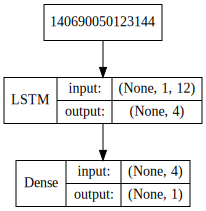

In [734]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

def plot_keras_model(model, show_shapes=True, show_layer_names=True):
    return SVG(model_to_dot(model, show_shapes=show_shapes, show_layer_names=show_layer_names).create(prog='dot',format='svg'))

plot_keras_model(model, show_shapes=True, show_layer_names=False)

### Train model using train data

In [735]:
model.fit(trainX, trainY, epochs=200, batch_size=1, verbose=2)

Epoch 1/200
 - 2s - loss: 0.0346
Epoch 2/200
 - 1s - loss: 0.0244
Epoch 3/200
 - 1s - loss: 0.0214
Epoch 4/200
 - 1s - loss: 0.0203
Epoch 5/200
 - 1s - loss: 0.0195
Epoch 6/200
 - 1s - loss: 0.0189
Epoch 7/200
 - 1s - loss: 0.0187
Epoch 8/200
 - 1s - loss: 0.0187
Epoch 9/200
 - 1s - loss: 0.0183
Epoch 10/200
 - 1s - loss: 0.0181
Epoch 11/200
 - 1s - loss: 0.0178
Epoch 12/200
 - 1s - loss: 0.0179
Epoch 13/200
 - 1s - loss: 0.0178
Epoch 14/200
 - 1s - loss: 0.0176
Epoch 15/200
 - 1s - loss: 0.0175
Epoch 16/200
 - 1s - loss: 0.0175
Epoch 17/200
 - 1s - loss: 0.0173
Epoch 18/200
 - 1s - loss: 0.0173
Epoch 19/200
 - 1s - loss: 0.0171
Epoch 20/200
 - 1s - loss: 0.0172
Epoch 21/200
 - 1s - loss: 0.0169
Epoch 22/200
 - 1s - loss: 0.0167
Epoch 23/200
 - 1s - loss: 0.0169
Epoch 24/200
 - 1s - loss: 0.0168
Epoch 25/200
 - 1s - loss: 0.0169
Epoch 26/200
 - 1s - loss: 0.0169
Epoch 27/200
 - 1s - loss: 0.0166
Epoch 28/200
 - 1s - loss: 0.0165
Epoch 29/200
 - 1s - loss: 0.0164
Epoch 30/200
 - 1s - lo

### Predict values using the trained model

In [736]:
trainPredict = model.predict(trainX)
# testPredictInTrain = model.predict(trainX[-look_back:, :, :])
testPredict = model.predict(testX)

In [737]:
testY.shape

(83,)

### Inverse transform the data

In [738]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
# testPredictInTrain = scaler.inverse_transform(testPredictInTrain)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

### Calculate RMSE for train and test predictions

In [739]:
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 75.13 RMSE
Test Score: 96.19 RMSE


### Generate Dates for index

In [740]:
dates = pd.date_range(start='1965-04', freq='MS', periods=trainY.shape[1])

### Create Dataframes for actual values and predicted values of train data

In [741]:
trainActual = pd.DataFrame({'Precipitation': trainY[0]})
trainActual.index = dates

trainPredictdf = pd.DataFrame({'Precipitation': trainPredict[:,0]})
trainPredictdf.index = dates

### Plot the predicted values
- Actual values - blue
- Predicted values - red

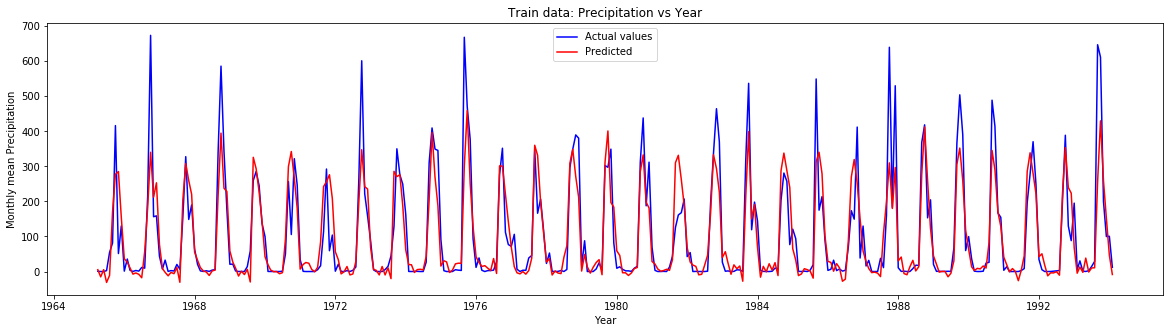

In [742]:
plt.figure(figsize=(20,5))
plt.plot(trainActual, color='blue', label='Actual values')
plt.plot(trainPredictdf, color='red', label='Predicted')
plt.title('Train data: Precipitation vs Year')
plt.xlabel('Year')
plt.ylabel('Monthly mean Precipitation')
plt.legend(loc='best')

### Generate Dates for index

In [747]:
testDates = pd.date_range(start=test_rainfall_data.index[0]+12, freq='MS', periods=test_rainfall_data.shape[0]-12-1)

### Create Dataframes for actual values and predicted values of test data

In [748]:
# testActual = pd.DataFrame({'Precipitation': testPredictInTrain[:,0] + testY[0]})
testActual = pd.DataFrame({'Precipitation': testY[0]})
testActual.index = testDates

testPredictdf = pd.DataFrame({'Precipitation': testPredict[:,0]})
testPredictdf.index = testDates

### Plot the forecasted values

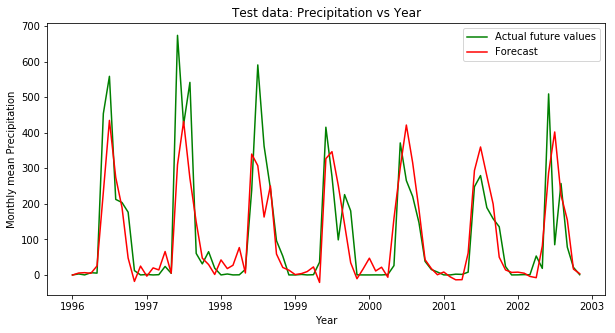

In [749]:
plt.figure(figsize=(10,5))
plt.plot(testActual, color='green', label='Actual future values')
plt.plot(testPredictdf, color='red', label='Forecast')
plt.title('Test data: Precipitation vs Year')
plt.xlabel('Year')
plt.ylabel('Monthly mean Precipitation')
plt.legend(loc='best')

In [673]:
index = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Train_RMSE = [126.23, 117.23, 104.45, 96.37, 93.37, 90.76, 89.29, 85.00, 83.40, 81.89, 82.50, 74.52]
Test_RMSE = [145.11, 140.89, 127.52, 121.96, 116.52, 113.09, 106.36, 107.95, 106.25, 108.13, 102.26, 91.59]

Text(0.5,1,'RMSE of Train and Test data at different look backs')

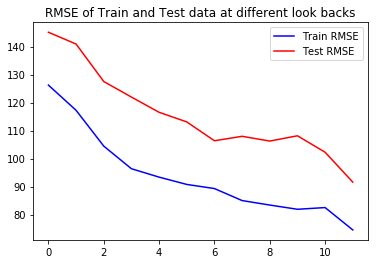

In [677]:
plt.plot(Train_RMSE, color='blue', label='Train RMSE')
plt.plot(Test_RMSE, color='red', label='Test RMSE')
plt.legend(loc='best')
plt.title('RMSE of Train and Test data at different look backs')